# Scrape MODIS Tau data from FTP site
- Get 2D phase and cloud cover data for the period 06-09 - 05.13

In [1]:
import sys
import time
# Add common resources folder to path
sys.path.append("/mnt/mcc-ns9600k/jonahks/git_repos/netcdf_analysis/Common/")
sys.path.append("/mnt/mcc-ns9600k/jonahks/git_repos/netcdf_analysis/")
sys.path.append("/home/jonahks/git_repos/netcdf_analysis/")
sys.path.append("/home/jonahks/git_repos/netcdf_analysis/Common/")
sys.path.append("/Users/jonahshaw/git_repos/netcdf_analysis/")
sys.path.append("/Users/jonahshaw/git_repos/netcdf_analysis/Common/")

from imports import (
    pd, np, xr, mpl, plt, sns, os, 
    datetime, sys, crt, gridspec,
    polyfit, ccrs, LinearRegression, metrics
    )

from functions import (
    masked_average, interpretNS, plot_slf_isotherms, 
    add_weights, process_caliop, process_for_slf,
    noresm_slf_to_df, regress_1d
    )

from ftplib import FTP # note this import here

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
host = os.uname()[1]
if 'jupyter' in host.split('-'): # Check if running on NIRD through the Jupyter Hub
    print('Running through MC2 Jupyter Hub')
    model_dir = '/mnt/mcc-ns9600k/jonahks/'
    os.chdir(model_dir)

else:  # Assume that we're running on a local machine and mounting NIRD
    print('Running on %s, attempting to mount ns9600k/jonahks/ from NIRD' % str(host))
    os.system('fusermount -zu ~/drivemount/')  # unmount first
    os.system('sshfs jonahks@login.nird.sigma2.no:"p/jonahks/" ~/drivemount/')    # Calling mountnird from .bashrc doesn't work
    model_dir = '/home/jonahks/drivemount/'
    os.chdir(model_dir)
    save_dir = '~/DATAOUT/'
    save_to = os.path.expanduser(save_dir)

output_dir = 'GOCCP_data/2Ddata'
case_dir = 'mnth15runs/'   # inconsistent label compared to jupy_test
mods_dir = 'inp_validation/'

# Check that each important directory can be accessed:    
access_paths = os.path.exists(mods_dir) and os.path.exists(output_dir) and os.path.exists(model_dir)
print('Can access all directory paths:', access_paths)

os.chdir(output_dir) # Move to where files will be saved and organized

Running through MC2 Jupyter Hub
Can access all directory paths: True


In [12]:
cd /mnt/mcc-ns9600k/jonahks/MODIS_COSP

/mnt/mcc-ns9600k/jonahks/MODIS_COSP


In [14]:
ls

## Function for getting the month of a file on this server

In [5]:
def getmonth(filename, year):
    parts = filename.split('_')
    date = [x for x in parts if year in x] # grab date regardless of position
    
    if len(date) > 1:
        print('Ambiguous naming of file: %s \n Cannot determine month.' % filename)
        return None
    else: 
        stamp = date[0]
        month = stamp[-2:]
        
        return month

## FTP download function from:
https://stackoverflow.com/questions/11573817/how-to-download-a-file-via-ftp-with-python-ftplib


In [49]:
# This function will redownload and replace if there is a previously existing file of the same name.
def download(filename):
    print("Downloading=> %s" % filename)
    
    #with open(filename,'wb') as f: # "use w+, wb"
    #    ftp.retrbinary('RETR ' + filename,f.write)
    
    fhandle = open(filename, 'wb')
    ftp.retrbinary('RETR ' + filename, fhandle.write)
    fhandle.close()
    
    print("Download Successful")
    

## Specify dates and strings for identifying file types.

In [7]:
startdate = '01-2006'
enddate = '12-2015'

# these strings will be used to select files, so make sure they are unique to your data
filetypes = ['MapLowMidHigh330m', 'MapLowMidHigh_Phase330m']

start_sep = np.array(startdate.split('-')).astype('int')
end_sep = np.array(enddate.split('-')).astype('int')

years = np.arange(start_sep[-1], end_sep[-1]+1) # Add one to the end to make the interval inclusive
first_month = start_sep[0]
last_month = end_sep[0]

## FTP initializing

Following: https://www.pythonforbeginners.com/code-snippets-source-code/how-to-use-ftp-in-python

In [43]:
# Site is: ftp://ftp.climserv.ipsl.polytechnique.fr/cfmip/GOCCP_v3/

ftp = FTP('ftp.climserv.ipsl.polytechnique.fr')   # connect to host, default port

ftp.login()               # user anonymous, passwd anonymous@

# ftp.cwd('cfmip/GOCCP_v3/2D_Maps/grid_2x2xL40/2018/avg') # could use a different directory here
# ftp.cwd('cfmip/GOCCP_v3/2D_Maps/grid_1x1xL40/2018/avg') # could use a different directory here
ftp.cwd('cfmip/MODIS/') # could use a different directory here
#ftp.retrlines('LIST')     # list directory contents 

'250 Commande CWD exÃ©cutÃ©e avec succÃ¨s'

In [30]:
ftp.nlst()

['.',
 '..',
 'MOD08_M3_NC.2002.11.C051.V02.nc',
 'MOD08_M3_NC.2009.10.C051.V02.nc',
 'MCD08_M3_NC.2005.02.C051.V02.nc',
 'MYD08_M3_NC.2008.07.C051.V02.nc',
 'MOD08_M3_NC.2001.04.C051.V02.nc',
 'MOD08_M3_NC.2002.01.C051.V02.nc',
 'MOD08_M3_NC.2010.01.C051.V02.nc',
 'MYD08_M3_NC.2004.11.C051.V02.nc',
 'MCD08_M3_NC.2006.07.C051.V02.nc',
 'MOD08_M3_NC.2003.08.C051.V02.nc',
 'MOD08_M3_NC.2003.10.C051.V02.nc',
 'MOD08_M3_NC.2005.02.C051.V02.nc',
 'MYD08_M3_NC.2002.11.C051.V02.nc',
 'MCD08_M3_NC.2005.12.C051.V02.nc',
 'MCD08_M3_NC.2009.03.C051.V02.nc',
 'MOD08_M3_NC.2003.07.C051.V02.nc',
 'MOD08_M3_NC.2009.09.C051.V02.nc',
 'MODIS-Data-for-Climate-Models.pdf',
 'MOD08_M3_NC.2003.04.C051.V02.nc',
 'MYD08_M3_NC.2007.03.C051.V02.nc',
 'MYD08_M3_NC.2005.03.C051.V02.nc',
 'MYD08_M3_NC.2008.08.C051.V02.nc',
 'MCD08_M3_NC.2004.09.C051.V02.nc',
 'MYD08_M3_NC.2003.06.C051.V02.nc',
 'MCD08_M3_NC.2011.04.C051.V02.nc',
 'MOD08_M3_NC.2009.08.C051.V02.nc',
 'MYD08_M3_NC.2004.06.C051.V02.nc',
 'MYD08_M3_NC

In [23]:
ftp.retrlines('LIST')     # list directory contents 

drwxr-xr-x   2 ftp      ftp         20480 May 21  2019 .
drwxr-xr-x   3 ftp      ftp          4096 May 27  2019 ..
-rw-r--r--   1 ftp      ftp      18390040 May 21  2019 cfadDbze94_obs4MIPs_CloudSat_R05_20060901_20060930.nc.gz
-rw-r--r--   1 ftp      ftp      19846839 May 21  2019 cfadDbze94_obs4MIPs_CloudSat_R05_20061001_20061031.nc.gz
-rw-r--r--   1 ftp      ftp      19346403 May 21  2019 cfadDbze94_obs4MIPs_CloudSat_R05_20061101_20061130.nc.gz
-rw-r--r--   1 ftp      ftp      19820846 May 21  2019 cfadDbze94_obs4MIPs_CloudSat_R05_20061201_20061231.nc.gz
-rw-r--r--   1 ftp      ftp      19109556 May 21  2019 cfadDbze94_obs4MIPs_CloudSat_R05_20070101_20070131.nc.gz
-rw-r--r--   1 ftp      ftp      18385829 May 21  2019 cfadDbze94_obs4MIPs_CloudSat_R05_20070201_20070228.nc.gz
-rw-r--r--   1 ftp      ftp      18269365 May 21  2019 cfadDbze94_obs4MIPs_CloudSat_R05_20070301_20070331.nc.gz
-rw-r--r--   1 ftp      ftp      18551293 May 21  2019 cfadDbze94_obs4MIPs_CloudSat_R05_20070401_2007

'226 TÃ©lÃ©chargement terminÃ©'

In [22]:
ftp.cwd('Monthly')

'250 Commande CWD exÃ©cutÃ©e avec succÃ¨s'

In [24]:
download('cfadDbze94_obs4MIPs_CloudSat_R05_20150201_20150228.nc.gz')

Downloading=> cfadDbze94_obs4MIPs_CloudSat_R05_20150201_20150228.nc.gz
Download Succesful


In [19]:
os.listdir()

['2013',
 '2014',
 '2015',
 '2012',
 'cfadDbze94_obs4MIPs_CloudSat_R05_20060901_20160930.nc.gz',
 '2008',
 '2006',
 '2007',
 '2009',
 '2010',
 'cfadDbze94_obs4MIPs_CloudSat_R05_20100101_20100131.nc.gz',
 '2011']

__CloudSat:__  
ftp://ftp.climserv.ipsl.polytechnique.fr/cfmip/CloudSat/CloudSat_Reflectivity/version_5/

# Main "for" loop

Current issue. Permissions are not changed to the user when the file is downloaded...

In [17]:
%ls CALIOP/

2006/         2009/         2012/         2015/
2007/         2010/         2013/         grid_1x1xL40/
2008/         2011/         2014/


In [16]:
%mkdir CALIOP/grid_1x1xL40

In [13]:
%pwd

'/Users/jonahshaw/obs'

In [48]:
# Navigate to the base folder for use. Here I'm just getting 2D data for CLDTOT variables.
# For 3D data: "/cfmip/GOCCP_v3/3D_CloudFraction/grid_2x2xL40/"
# ftp.cwd('/cfmip/GOCCP_v3/2D_Maps/grid_1x1xL40') # could use a different directory here
ftp.cwd('/cfmip/MODIS') # could use a different directory here

# Navigate to the base folder for use. Here I'm just getting 2D data for CLDTOT variables.
# os.chdir("/%s/GOCCP_data/2Ddata" % model_dir)
os.chdir("/mnt/mcc-ns9600k/jonahks/MODIS_COSP/")

toscrape = []
years = ['2007','2008','2009','2010']
tag = 'MCD08'
files = ftp.nlst()
files.sort()

# print(files)

for i in files:
    for j in years:
        if (j in i) and (tag in i):
            toscrape.append(i)

for i in toscrape:
#     print(i)
    download(i)

print(len(allscrapes))
# print(allscrapes)

Downloading=> MCD08_M3_NC.2007.01.C051.V02.nc
Download Succesful
Downloading=> MCD08_M3_NC.2007.02.C051.V02.nc
Download Succesful
Downloading=> MCD08_M3_NC.2007.03.C051.V02.nc
Download Succesful
Downloading=> MCD08_M3_NC.2007.04.C051.V02.nc
Download Succesful
Downloading=> MCD08_M3_NC.2007.05.C051.V02.nc
Download Succesful
Downloading=> MCD08_M3_NC.2007.06.C051.V02.nc
Download Succesful
Downloading=> MCD08_M3_NC.2007.07.C051.V02.nc
Download Succesful
Downloading=> MCD08_M3_NC.2007.08.C051.V02.nc
Download Succesful
Downloading=> MCD08_M3_NC.2007.09.C051.V02.nc
Download Succesful
Downloading=> MCD08_M3_NC.2007.10.C051.V02.nc
Download Succesful
Downloading=> MCD08_M3_NC.2007.11.C051.V02.nc
Download Succesful
Downloading=> MCD08_M3_NC.2007.12.C051.V02.nc
Download Succesful
Downloading=> MCD08_M3_NC.2008.01.C051.V02.nc
Download Succesful
Downloading=> MCD08_M3_NC.2008.02.C051.V02.nc
Download Succesful
Downloading=> MCD08_M3_NC.2008.03.C051.V02.nc
Download Succesful
Downloading=> MCD08_M3_NC

In [50]:
os.listdir()

['MCD08_M3_NC.2010.10.C051.V02.nc',
 'MCD08_M3_NC.2010.12.C051.V02.nc',
 'MCD08_M3_NC.2009.04.C051.V02.nc',
 'MCD08_M3_NC.2007.11.C051.V02.nc',
 'MCD08_M3_NC.2010.02.C051.V02.nc',
 'MCD08_M3_NC.2010.06.C051.V02.nc',
 'MCD08_M3_NC.2007.04.C051.V02.nc',
 'MCD08_M3_NC.2007.10.C051.V02.nc',
 'MCD08_M3_NC.2008.08.C051.V02.nc',
 'MCD08_M3_NC.2008.09.C051.V02.nc',
 'MCD08_M3_NC.2009.02.C051.V02.nc',
 'MCD08_M3_NC.2008.11.C051.V02.nc',
 'MCD08_M3_NC.2008.06.C051.V02.nc',
 'MCD08_M3_NC.2009.08.C051.V02.nc',
 'MCD08_M3_NC.2008.12.C051.V02.nc',
 'MCD08_M3_NC.2007.07.C051.V02.nc',
 'MCD08_M3_NC.2007.03.C051.V02.nc',
 'MCD08_M3_NC.2008.01.C051.V02.nc',
 'MCD08_M3_NC.2007.12.C051.V02.nc',
 'MCD08_M3_NC.2008.02.C051.V02.nc',
 'MCD08_M3_NC.2009.05.C051.V02.nc',
 'MCD08_M3_NC.2007.05.C051.V02.nc',
 'MCD08_M3_NC.2008.07.C051.V02.nc',
 'MCD08_M3_NC.2010.09.C051.V02.nc',
 'MCD08_M3_NC.2010.07.C051.V02.nc',
 'MCD08_M3_NC.2010.08.C051.V02.nc',
 'MCD08_M3_NC.2010.04.C051.V02.nc',
 'MCD08_M3_NC.2007.08.C051.V

In [52]:
files = os.listdir()
testfile = xr.open_dataset(files[0])

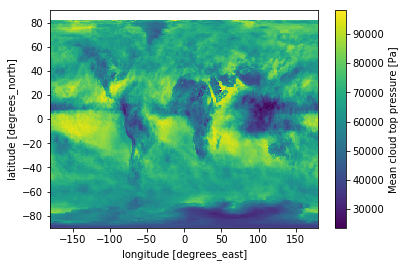

In [55]:
testfile['Cloud_Top_Pressure_Total_Mean'].plot()

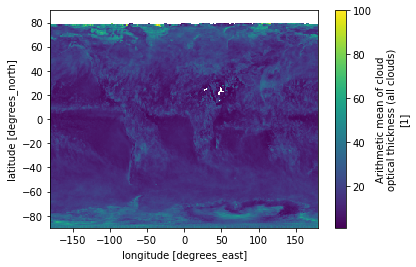

In [57]:
testfile['Cloud_Optical_Thickness_Total_Mean'].plot()

In [17]:
ftp.retrlines('LIST')     # list directory contents 

drwxr-xr-x   3 ftp      ftp          4096 May 27  2019 .
drwxr-xr-x   6 ftp      ftp         20480 May 27  2019 ..
-rw-r--r--   1 ftp      ftp      1600227621 May 21  2019 cfadDbze94_obs4MIPs_CloudSat_R05_20060901_20160930.nc.gz
-rw-r--r--   1 ftp      ftp       2038172 May 21  2019 CloudSat_Reflectivity_Height_Histogram_cfadDbze94_Quality_Statement.pdf
drwxr-xr-x   2 ftp      ftp         20480 May 21  2019 Monthly


'226 TÃ©lÃ©chargement terminÃ©'

In [9]:
download('MapHigh330m_201802_avg_CFMIP2_sat_3.1.2.nc')

Downloading=> MapHigh330m_201802_avg_CFMIP2_sat_3.1.2.nc
Download Succesful


In [298]:
import stat
path= 'MapHigh330m_201801_avg_CFMIP2_sat_3.1.2.nc'
st = os.stat(path)
os.chmod(path, st.st_mode | stat.S_IWOTH)

In [248]:
# ftp.retrlines('LIST') # print files and directories in current directory, useful for navigating around with cwd

## FTP initializing

Following: https://www.pythonforbeginners.com/code-snippets-source-code/how-to-use-ftp-in-python

In [40]:
# Site is: ftp://ftp.climserv.ipsl.polytechnique.fr/cfmip/GOCCP_v3/

ftp = FTP('ftp.climserv.ipsl.polytechnique.fr')   # connect to host, default port

ftp.login()               # user anonymous, passwd anonymous@

ftp.cwd('cfmip/GOCCP_v3/2D_Maps/grid_2x2xL40/2018/avg')
#ftp.retrlines('LIST')     # list directory contents 

'250 Commande CWD exÃ©cutÃ©e avec succÃ¨s'

In [7]:
ftp.retrlines('LIST')

drwxr-xr-x   4 ftp      ftp          4096 Jan 14  2019 .
drwxrwxr-x   5 ftp      ftp          4096 Feb  7  2018 ..
drwxr-xr-x   3 ftp      ftp        167936 Jan 14  2019 daily
-rw-r--r--   1 ftp      ftp        201552 Jan  9  2019 MapHigh330m_201001_avg_CFMIP2_sat_3.1.2.nc
-rw-r--r--   1 ftp      ftp        201184 Jan  9  2019 MapHigh330m_201002_avg_CFMIP2_sat_3.1.2.nc
-rw-r--r--   1 ftp      ftp        201552 Jan  9  2019 MapHigh330m_201003_avg_CFMIP2_sat_3.1.2.nc
-rw-r--r--   1 ftp      ftp        201428 Jan  9  2019 MapHigh330m_201004_avg_CFMIP2_sat_3.1.2.nc
-rw-r--r--   1 ftp      ftp        201552 Jan  9  2019 MapHigh330m_201005_avg_CFMIP2_sat_3.1.2.nc
-rw-r--r--   1 ftp      ftp        201428 Jan  9  2019 MapHigh330m_201006_avg_CFMIP2_sat_3.1.2.nc
-rw-r--r--   1 ftp      ftp        201552 Jan  9  2019 MapHigh330m_201007_avg_CFMIP2_sat_3.1.2.nc
-rw-r--r--   1 ftp      ftp        201184 Jan  9  2019 MapHigh330m_201008_avg_CFMIP2_sat_3.1.2.nc
-rw-r--r--   1 ftp      ftp        20142

'226 TÃ©lÃ©chargement terminÃ©'